# Predicting the average session duration of a player via experience level

## Introduction

## Methods & Results

#### Preliminary exploratory data analysis:
Step 1) Imported libraries and read in the `players.csv` and `sessions.csv` datasets from the Minecraft server study.

Step 2) Cleaned and tidied both datasets by selecting relevant columns and converting timestamps to usable formats.

Step 3) Merged the datasets using `hashedEmail` to link player profiles with their individual play sessions.

Step 4) Split the data into training and testing sets (only working with the training set until the final evaluation).

Step 5) Summarized the training set to calculate average session duration for each player.

Step 6) Visualized the relationship between session duration and experience level to explore potential patterns.

#### Performing a Linear Regression Analysis:
The objective of this project was to determine whether a player’s self-reported experience level could predict their average session duration. To evaluate this relationship, we built a linear regression model using only the training data and then tested it on unseen data to assess generalizability.

---

Step 1) Created a linear regression model to predict average session duration using experience level as the explanatory variable.

Step 2) Fitted the model using the training data only, avoiding data leakage.

Step 3) Evaluated the model using predictions on the test set and calculated performance metrics.

Step 4) Visualized predicted versus actual session durations to assess the model’s effectiveness.

Step 5) Interpreted results and assessed whether experience level is a meaningful predictor of play behavior.

---

We believe utilizing a linear regression model is appropriate as it provides a clear and interpretable way to understand the relationships between player characteristics (such as experience and hours played) and the total data contribution as a continuous outcome. Moreover, linear regression assumes that there is a linear relationship between the predictors and the dependent variable, which makes it useful for quantifying how each player characteristic contributes to the total data contribution. Furthermore, linear regression works well on small datasets whereas k-nn regression can be more sensitive to small sample sizes and noise (especially when the predictor is not numeric).

### Preliminary exploratory data analysis:

#### Importing Libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Importing Players and Sessions Datasets
We utilized read_csv to import both of the datasets from the online directory.

In [2]:
players = read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
sessions = read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Cleaning & Wrangling the Data
We clean and prepare both datasets. For the players dataset, we remove irrelevant variables. For sessions, we separate date and time, convert to POSIX datetime, and compute session duration in minutes.

In [3]:
set.seed(1)

# Remove subscription and gender variables from player dataset
players_clean <- select(players, experience, hashedEmail, played_hours, name, age)
head(players_clean)

# Separate start_time and end_time into individual date & time columns for session dataset, and then compute session duration
sessions_clean <- sessions |>
  separate(start_time, into = c("start_date", "start_time"), sep = " ") |>
  separate(end_time, into = c("end_date", "end_time"), sep = " ") |>
  mutate(start_datetime = parse_date_time(paste(start_date, start_time), orders = "dmy HM"),
         end_datetime = parse_date_time(paste(end_date, end_time), orders = "dmy HM"),
         duration_mins = as.numeric(difftime(end_datetime, start_datetime, units = "mins"))) |>
  filter(!is.na(duration_mins)) |>
  select(hashedEmail, duration_mins)

experience,hashedEmail,played_hours,name,age
<chr>,<chr>,<dbl>,<chr>,<dbl>
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9
Veteran,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,17
Veteran,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,17
Amateur,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,21
Regular,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,21
Amateur,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,17


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `end_datetime = parse_date_time(paste(end_date, end_time),
  orders = "dmy HM")`.
Caused by warning:
!  2 failed to parse.”


$Figure$ $1$

**Legend**: This table shows the first six rows of the cleaned `players_clean` dataset after removing irrelevant columns and tidying the data. Each row corresponds to an individual player, showing their experience level, anonymized identifier (hashedEmail), total hours played, name, and age.


**Interpretation**: During the date-time conversion step, a warning appeared indicating that two values failed to parse correctly using `parse_date_time()`. This typically occurs when timestamps are missing or improperly formatted (e.g., invalid dates or times). These rows were automatically filtered out using `filter(!is.na(duration_mins))` to ensure only valid session durations were included in the analysis. Since only two rows were affected, this had a negligible impact on the overall results.

#### Merging the Cleaned Datasets
We merge the cleaned players and sessions datasets using the common key `hashedEmail` in order to split into training and testing sets. This allows us to analyze player characteristics in relation to their session behavior.

In [4]:
set.seed(1)

# Combining both datasets in order to split into training and testing sets 
combined_data <- players_clean |>
  inner_join(sessions_clean, by = "hashedEmail")

#### Splitting the Data into Training and Testing Sets
Before working on our model, we need to split the data into training and testing sets. We split the combined dataset into training (75%) and testing (25%) sets, stratifying by experience level. We do not use the test set until the very end to avoid data leakage.

In [5]:
set.seed(123)

# Splitting dataframe into training and testing datasets
split <- initial_split(combined_data, prop = 0.75, strata = experience)

train_df <- training(split)
test_df <- testing(split)

head(train_df)
head(test_df)

experience,hashedEmail,played_hours,name,age,duration_mins
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,7
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,56
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,75
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,45
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,109
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,15


experience,hashedEmail,played_hours,name,age,duration_mins
<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,74
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,44
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,12
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,119
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,211
Pro,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,9,40


$Figure$ $2$

**Legend**: This table shows the first six rows of the training dataset, created by stratified splitting of the full dataset (75% for training, 25% for testing). Each row represents an individual play session and includes the player’s experience level, hashed identifier, playtime in hours, name, age, and session duration in minutes.


**Interpretation**: This confirms that the training set has preserved the key structure and variables from the original data. Multiple sessions for the same player (e.g., Morgan) appear as separate rows, each with a unique session duration. This dataset will be used for all model development and exploratory analysis to avoid data leakage.

---

$Figure$ $3$

**Legend**: This table shows the first six rows of the testing dataset, which will be used solely for final model evaluation. It includes the same structure as the training set and was created using stratified sampling to ensure proportional representation of experience levels.


**Interpretation**: The test set also contains multiple sessions for the same player, showing how session duration can vary widely. This range underscores the variability we hope to capture in our modeling. No summaries or models are built on this data until the very end of the analysis.

#### Summarizing the Training Data
We calculate the average session duration for each player using only the training data. This will serve as the basis for both exploratory analysis and model fitting.

In [6]:
# Summarize average session duration per player in training set
train_summary <- train_df |>
  group_by(hashedEmail, experience, age, name) |>
  summarize(avg_duration = mean(duration_mins), .groups = "drop")

# Prepare test set summary (for evaluation later)
test_summary <- test_df |>
  group_by(hashedEmail, experience, age, name) |>
  summarize(avg_duration = mean(duration_mins), .groups = "drop")

head(train_summary)
head(test_summary)

hashedEmail,experience,age,name,avg_duration
<chr>,<chr>,<dbl>,<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,20,Isaac,53.00000
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,21,Lyra,30.00000
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,17,Winslow,32.83333
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,Pro,17,Knox,35.00000
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,Veteran,19,Callum,10.00000
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Amateur,14,Kyrie,31.39286


hashedEmail,experience,age,name,avg_duration
<chr>,<chr>,<dbl>,<chr>,<dbl>
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,17,Osiris,11
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,17,Winslow,24
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,Amateur,21,Hugo,50
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,Amateur,14,Kyrie,26
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,Beginner,37,Aurora,18
200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,Amateur,17,Anastasia,12


$Figure$ $4$

**Legend**: This table displays the first six rows of the summarized training set, where each row now represents a single player. The average session duration was computed by grouping all session durations for each player in the training set.




**Interpretation**: We can see variability in average session duration even among players with the same experience level (for example, both Pro and Regular players appear with different average values). This summary is now in the correct format for regression modeling, where each observation corresponds to one player with a single outcome (`avg_duration`) and predictor (`experience`).



---

$Figure$ $5$

**Legend**: This table presents the first six rows of the summarized test set. Like the training summary, each player appears only once, with an average session duration based on all of their test sessions.


**Interpretation**: The test set summary mirrors the structure of the training summary and will be used solely for evaluating the model’s predictions. The spread of average durations (especially within the same experience group), highlights the challenge of building a predictive model based on experience alone.

#### Visualizing Average Session Duration by Player Experience
We create a bar chart showing the average session duration for each experience level using the training set only.

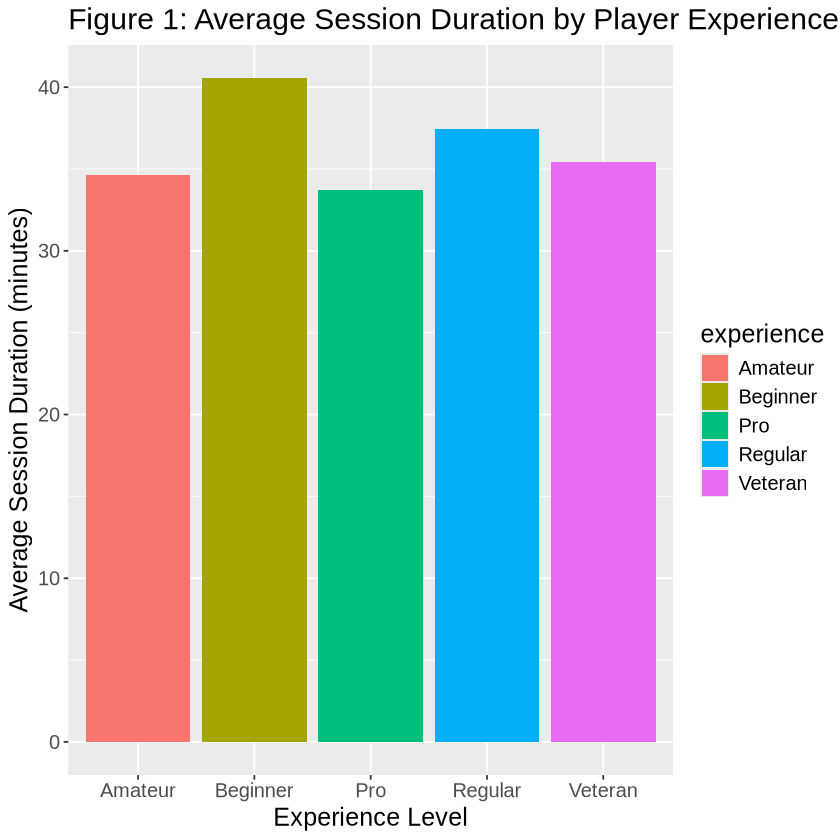

In [7]:
# Summarize average session duration by experience
eda_summary_train <- train_summary |>
  group_by(experience) |>
  summarize(mean_duration = mean(avg_duration), count = n())

# Plot
ggplot(eda_summary_train, aes(x = experience, y = mean_duration, fill = experience)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure 6: Average Session Duration by Player Experience (Training Set)",
        x = "Experience Level",
        y = "Average Session Duration (minutes)")+
    theme(text = element_text(size = 15))

$Figure$ $6$

**Legend**: This bar chart displays the mean average session duration for players in each experience group, calculated using only the training data. Each bar represents the average of all players within a given experience level, where individual values were computed as the mean duration across all sessions for each player.

**Interpretation**: The differences between experience groups are relatively modest. Players in the "Beginner" and "Regular" categories show slightly higher average session durations, while "Pro" and "Amateur" players have lower averages. However, the differences are not substantial enough to suggest a strong or consistent trend. These findings indicate that while experience level may be loosely associated with session duration, it is unlikely to serve as a robust or reliable predictor. This is consistent with the later regression results, which found no statistically significant effect.

### Regression Analysis (Linear Regression)
We fit a linear regression model using the training data to predict average session duration from experience level.

In [8]:
# Fit linear regression model
lm_model <- linear_reg() |>
  set_engine("lm") |>
  fit(avg_duration ~ experience, data = train_summary)

summary(lm_model$fit)


Call:
stats::lm(formula = avg_duration ~ experience, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-35.55 -25.42 -14.45  15.49 111.58 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         34.6158     6.1277   5.649 1.75e-07 ***
experienceBeginner   5.9372    10.5089   0.565    0.573    
experiencePro       -0.8991    13.2373  -0.068    0.946    
experienceRegular    2.8562     9.9752   0.286    0.775    
experienceVeteran    0.8065    10.1373   0.080    0.937    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.2 on 93 degrees of freedom
Multiple R-squared:  0.004348,	Adjusted R-squared:  -0.03848 
F-statistic: 0.1015 on 4 and 93 DF,  p-value: 0.9817


$Figure$ $7$

**Legend**: This output shows the results of a linear regression model trained to predict a player’s average session duration based on their self-reported experience level. The model was fit using the training set only. The intercept represents the average duration for the baseline category ("Amateur"), and the other coefficients reflect differences relative to that group.

**Interpretation**: The model’s R² value is extremely low (0.004348), indicating that experience level explains less than 1% of the variability in session duration. Additionally, none of the experience-level coefficients are statistically significant (all p-values > 0.5), suggesting that differences between groups are not reliable or generalizable. This confirms that experience alone is not a strong or meaningful predictor of how long players engage in sessions. The model may be underfitting the data, or the predictor simply lacks explanatory power for this outcome.

#### Visualizing Predicted vs Actual Values on the Test Set
We use the test set to evaluate the model by comparing predicted values to actual session durations.

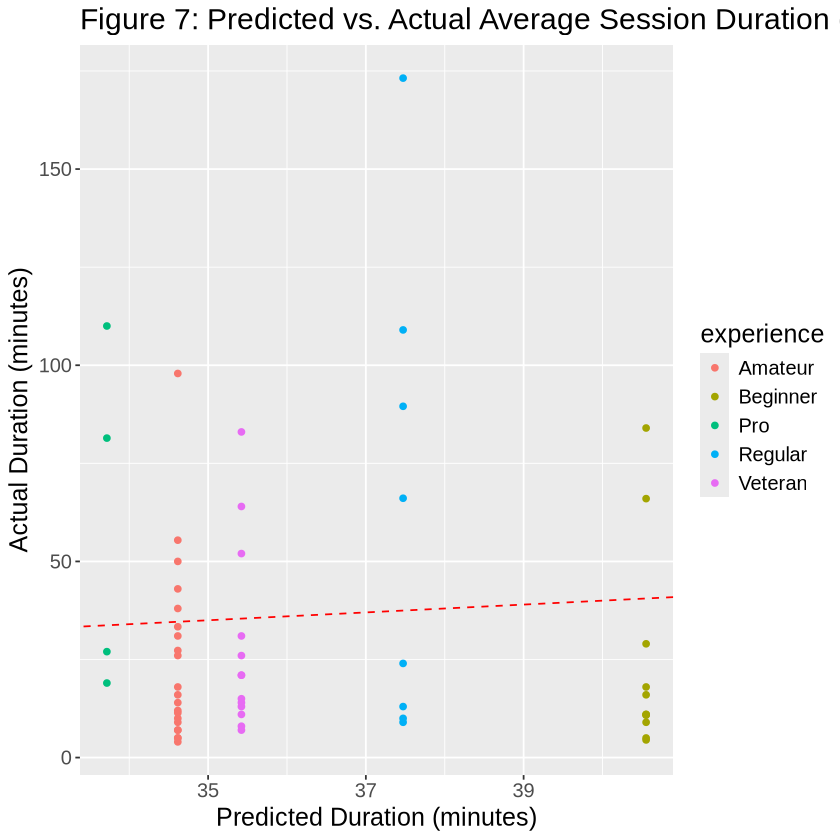

In [10]:
# Predict on test set
test_summary <- test_summary |>
  mutate(pred = predict(lm_model, test_summary)$.pred)

# Plot
ggplot(test_summary, aes(x = pred, y = avg_duration, color = experience)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(
    title = "Figure 8: Predicted vs. Actual Average Session Duration (Test Set)",
        x = "Predicted Duration (minutes)",
        y = "Actual Duration (minutes)") +
    theme(text = element_text(size = 15))

$Figure$ $8$

**Legend**: Each point in this scatterplot represents a player from the test set. The x-axis shows the session duration predicted by the model, and the y-axis shows that player's actual observed average session duration. The dashed red line represents the ideal case where predicted values equal actual values.

**Interpretation**: The wide scatter of points around the dashed line suggests a poor fit as predictions from the model do not reliably align with actual values. There is no visible trend or clustering that would indicate strong predictive power. This supports the statistical results from the regression summary, where the R² was close to zero and no coefficients were significant. In practical terms, this confirms that a player's self-reported experience level is **not a useful standalone predictor** of how long they tend to play in each session. It also highlights that even if initial exploratory plots suggest possible differences between groups, those differences may not generalize well when evaluated with a predictive model.

## Discussion